# ベイズ線形回帰

In [1]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Random
using Plots.PlotMeasures; px

0.254mm

In [2]:
#シード固定とプログラムで使う型を決める
rng = MersenneTwister(20220105)
FT = Float32

Float32

## 1.問題設定
予測する関数を設定

シグモイド関数
$$
f(x) = \frac{1}{1+\exp^{-ax}}
$$

In [3]:
exact(x, a=5) = (1 + exp(-a*x))^-1

exact (generic function with 2 methods)

データ生成

In [4]:
function make_data(FT=Float32; N=30, σₜ = 0.1, lₓ = 1)
    @eval N = $(N)
    @eval σₜ = $(σₜ)
    @eval lₓ = $(lₓ)
    # x_data: [-lₓ, lₓ)の一様分布
    # t_data: exact + 平均0, 標準偏差σₜの正規分布
    @eval x_data = Vector{$(FT)}((rand(rng, $(FT), N) .-0.5) .*(2*lₓ))
    @eval t_data = Vector{$(FT)}(exact.(x_data) .+ randn(rng, $(FT), N) .*σₜ)
    @eval x_dense = Vector{$(FT)}([i for i=-lₓ:2lₓ/50:lₓ])
    @eval t_dense = exact.(x_dense)
end

make_data (generic function with 2 methods)

In [5]:
make_data();

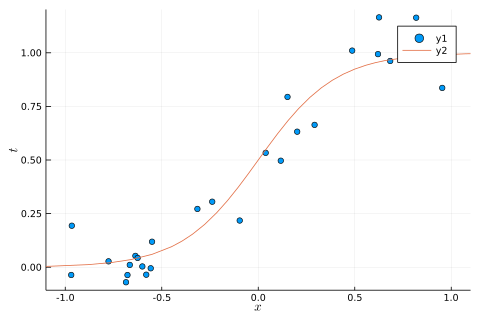

In [6]:
scatter(x_data, t_data, dpi=20, xlabel=L"x", ylabel=L"t")
plot!(exact, xlim=(-1.1,1.1))

## 2.ベイズ線形回帰の実装

計画行列$\Phi$を生成する関数

In [7]:
# Matrixへの変換が面倒なので最初から行列を確保してから代入している
function gen_design_matrix!(mat, xn, func_bases)
    for (i, x) in enumerate(xn)
        mat[i, :] = func_bases(x) 
    end
    return mat
end

gen_design_matrix! (generic function with 1 method)

ベイズ線形回帰を実行して$\mu(x)$, $\sigma(x)$を返す関数

In [8]:
function bayes_linear_regression(FT, xtrain, ytrain, xtest, func_bases, β, α, n=size(func_bases(1))[1])
    Φ = zeros(FT, size(xtrain)[1], n)
    Φ = gen_design_matrix!(Φ, xtrain, func_bases)
    m = size(Φ)[2]
    S = Matrix{FT}(inv(β .* Φ' * Φ + α*I(m)))
    w = Vector{FT}(β .*S *Φ' *ytrain)
    ϕ = zeros(FT, size(xtest)[1], n)
    ϕ = gen_design_matrix!(ϕ, xtest, func_bases)'
    μ = ϕ' * w
    σ² = Matrix{FT}(β^-1 .+ ϕ' * S * ϕ)
    return (μ, Vector{FT}(diag(σ²).^0.5))
end

bayes_linear_regression (generic function with 2 methods)

### 多項式関数

$$
\phi_j(x) = x^j \quad (j=0, 1, \cdots, M)
$$

In [9]:
bases_polynomial(x, M) = [x^j for j in 0:M]

bases_polynomial (generic function with 1 method)

In [10]:
#引数Mを固定した関数
bases_poly4(x) = bases_polynomial(x, 4)

bases_poly4 (generic function with 1 method)

In [11]:
# 計算
μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_poly4, 10, 1e-8)

(Float32[0.0839861, 0.06350136, 0.046132818, 0.03192886, 0.020925298, 0.013145432, 0.008599989, 0.007287234, 0.00919307, 0.014290649  …  1.0478799, 1.0614567, 1.0698755, 1.0726715, 1.0693681, 1.0594755, 1.0424919, 1.0179029, 0.98518145, 0.9437881], Float32[0.40748045, 0.37841105, 0.35888404, 0.34656927, 0.3393114, 0.3353308, 0.33330014, 0.33231887, 0.33183566, 0.33155704  …  0.34468362, 0.34450847, 0.34344026, 0.34152222, 0.33905664, 0.3367377, 0.33581296, 0.3382398, 0.34674448, 0.36464298])

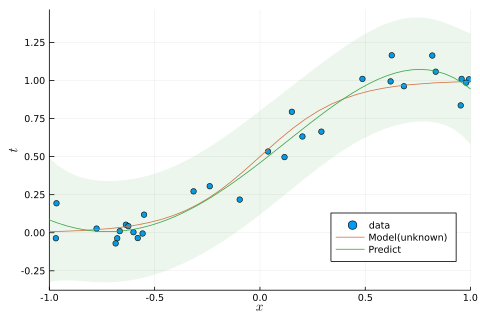

In [12]:
# プロット
param = Dict(:dpi=>20, :legend=>:bottomright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
scatter(x_data, t_data, label="data"; param...)
plot!(exact, label="Model(unknown)")
plot!(x_dense, μ_dense, ribbon=σ_dense, label="Predict", fillalpha=0.1)

### ガウス関数基底

$$
\phi_j(x) = \exp \left[ -\frac{(x-\mu_j)^2}{2\sigma^2} \right]
$$

In [13]:
function bases_gaussian(x, xmin, xmax, n, σ)
    μ = [i for i=range(xmin, xmax, length=n)]
    ϕ = exp.(-(x .-μ).^2 ./(2*σ^2))
end

bases_gaussian (generic function with 1 method)

In [32]:
bases_gaussian10(x) = bases_gaussian(x, -1, 1, 10, 0.15)

bases_gaussian10 (generic function with 1 method)

In [15]:
# 計算
μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian10, 10, 1e-3)

(Float32[0.080624394, 0.07779696, 0.06937062, 0.056437906, 0.040623456, 0.023794262, 0.007998119, -0.0043630423, -0.010330288, -0.0064752884  …  1.0755644, 1.072496, 1.0648392, 1.0579159, 1.054069, 1.0518501, 1.0459975, 1.0283159, 0.98969513, 0.92310375], Float32[0.3971526, 0.38387194, 0.372132, 0.37139657, 0.38033026, 0.38732383, 0.38185218, 0.36365393, 0.3433861, 0.33409598  …  0.3575572, 0.35611337, 0.36674, 0.3785676, 0.3795742, 0.36758238, 0.35165808, 0.34445032, 0.35032168, 0.36191624])

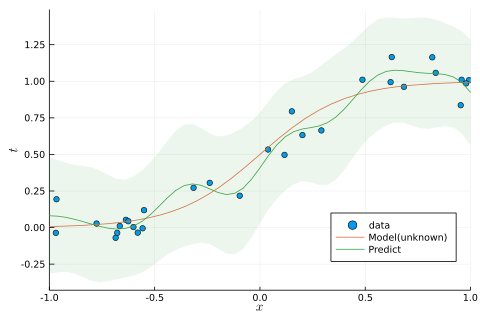

In [16]:
# プロット
param = Dict(:dpi=>20, :legend=>:bottomright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
scatter(x_data, t_data, label="data"; param...)
plot!(exact, label="Model(unknown)")
plot!(x_dense, μ_dense, ribbon=σ_dense, label="Predict", fillalpha=0.1)

繰り返し用関数

In [17]:
function myplot(x_data, t_data, x_dense, μ_dense, σ_dense; desc="")
    param = Dict(:dpi=>20, :legend=>:outerbottomright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    plt = scatter(x_data, t_data, label="data $(desc)"; param...)
    plot!(exact, label="Model(unknown)")
    plot!(x_dense, μ_dense, ribbon=σ_dense, label="Predict", fillalpha=0.1) 
    return plt
end

myplot (generic function with 1 method)

In [30]:
function myplotanim(x_data, t_data, x_dense, μ_dense, σ_dense; desc="")
#     param = Dict(:dpi=>150, :legend=>:outerbottomright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    param = Dict(:dpi=>150, :legend=>:outerbottomright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1), :ylim=>(-2, 2))
    plt = scatter(x_data, t_data, label="data $(desc)"; param...)
    plot!(exact, label="Model(unknown)")
    plot!(x_dense, μ_dense, ribbon=σ_dense, label="Predict", fillalpha=0.1) 
end

myplotanim (generic function with 1 method)

In [19]:
function myplots(plts; figsize=(1000, 1000))
    plot(plts..., layout=(size(plts)[1], 1), size=figsize, right_margin=50px, dpi=20)
end

myplots (generic function with 1 method)

In [20]:
function make_data_rtn(FT=Float32; N=30, σₜ = 0.1, lₓ = 1)
    x_data = Vector{FT}((rand(rng, FT, N) .-0.5) .*(2*lₓ))
    t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, N) .*σₜ)
    x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
    t_dense = exact.(x_dense)
    return (x_data, t_data, x_dense, t_dense)
end

make_data_rtn (generic function with 2 methods)

## 3.サンプル
ガウス過程での様子を見る

### 3.1.データ点を増やす

┌ Info: Saved animation to 
│   fn = C:\Users\kohei\OneDrive\講義\M1-2 秋\現代物理学\code\report_4-2.gif
└ @ Plots C:\Users\kohei\.julia\packages\Plots\8GUYs\src\animation.jl:102


Plots.AnimatedGif("C:\\Users\\kohei\\OneDrive\\講義\\M1-2 秋\\現代物理学\\code\\report_4-2.gif")
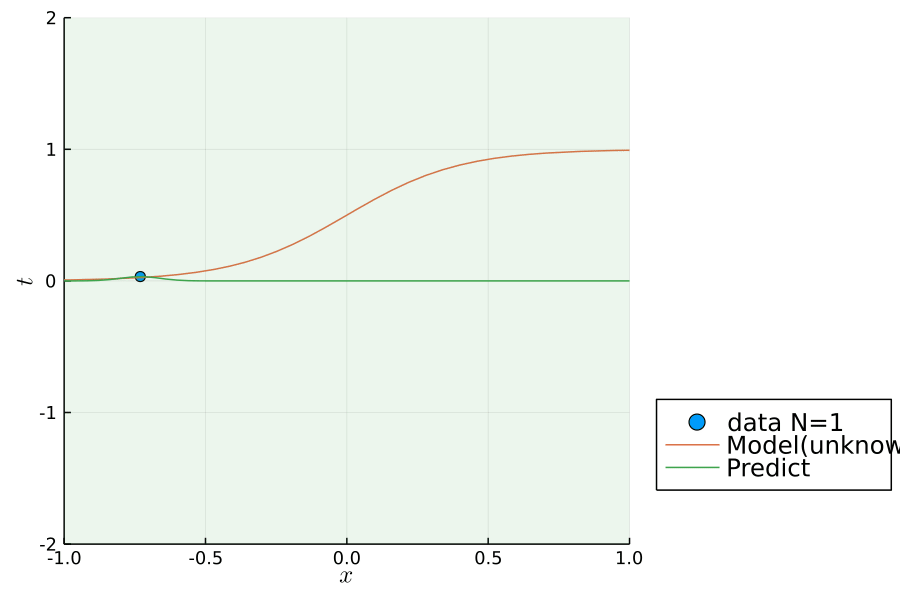

In [39]:
plts = []
pltflg = [1, 5, 10, 50]
x_data = Vector{FT}((rand(rng, FT, 1) .-0.5) .*(2*lₓ))
t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, 1) .*σₜ)
x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
t_dense = exact.(x_dense)
bases_gaussian100(x) = bases_gaussian(x, -1, 1, 30, 0.05)
# bases_gaussian10(x) = bases_gaussian(x, -1, 1, 10, 0.15)
anim = @animate for i in 1:1:50
    μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian100, 10, 1e-3)
    plt = myplotanim(x_data, t_data, x_dense, μ_dense, σ_dense, desc="N=$(i)")
    push!(x_data, (rand(rng, FT) .-0.5) .*(2*lₓ))
    push!(t_data, exact.(x_data[end]) .+ randn(rng, FT) .*σₜ)
    if i in pltflg
       push!(plts, plt) 
    end
end

gif(anim, "report_4-2.gif", fps=2)

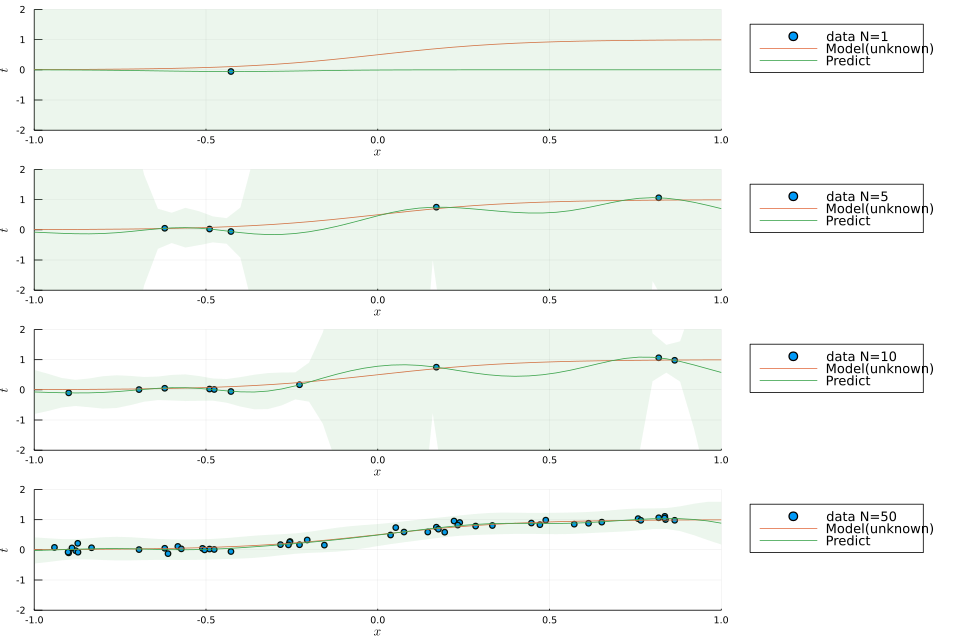

In [34]:
myplots(plts, figsize=(1200, 800))

### 3.2.パラメータを変える

In [23]:
x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)

(Float32[0.91381335, -0.05577731, -0.5419555, -0.5582919, -0.727721, -0.70579934, 0.70240164, -0.7015364, 0.27071476, 0.30941272, -0.6806171, -0.54256344, 0.71287894, -0.2003696, -0.8135917, -0.3249452, 0.18314385, 0.4952991, 0.5092108, -0.85246325], Float32[1.007573, 0.6475707, 0.032967143, -0.18232301, 0.09493756, 0.22222792, 1.0906758, 0.12723592, 0.70965123, 0.8498384, -0.09019261, 0.13522324, 0.96265507, 0.33942237, -0.094387755, 0.0099947695, 0.82558346, 0.78130716, 0.86622393, -0.056492098], Float32[-1.0, -0.96, -0.92, -0.88, -0.84, -0.8, -0.76, -0.72, -0.68, -0.64  …  0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96, 1.0], Float32[0.006692851, 0.008162573, 0.009951803, 0.012128434, 0.014774035, 0.01798621, 0.021881271, 0.02659699, 0.03229546, 0.039165728  …  0.96083426, 0.9677046, 0.973403, 0.97811866, 0.98201376, 0.985226, 0.9878715, 0.99004817, 0.99183744, 0.9933072])

#### $\alpha$

α = 1.0e-6
α = 0.001
α = 1.0
α = 1000.0


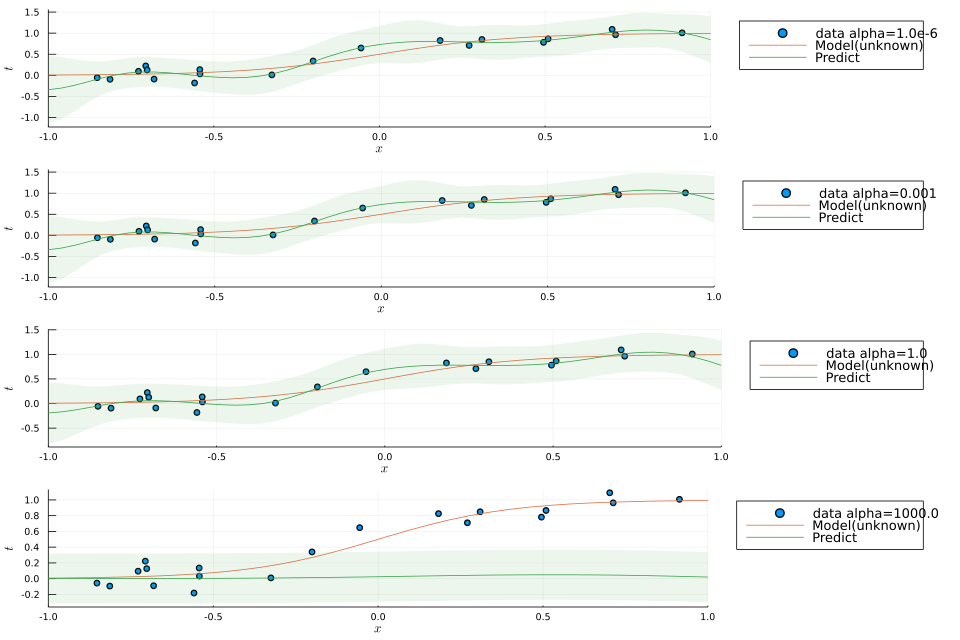

In [24]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for α in [1e-6, 1e-3, 1, 1e3]
    @show α
    μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian10, 10, α)
    plt = myplot(x_data, t_data, x_dense, μ_dense, σ_dense, desc="alpha=$(α)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))

#### $\beta$

β = 1
β = 10
β = 100
β = 1000


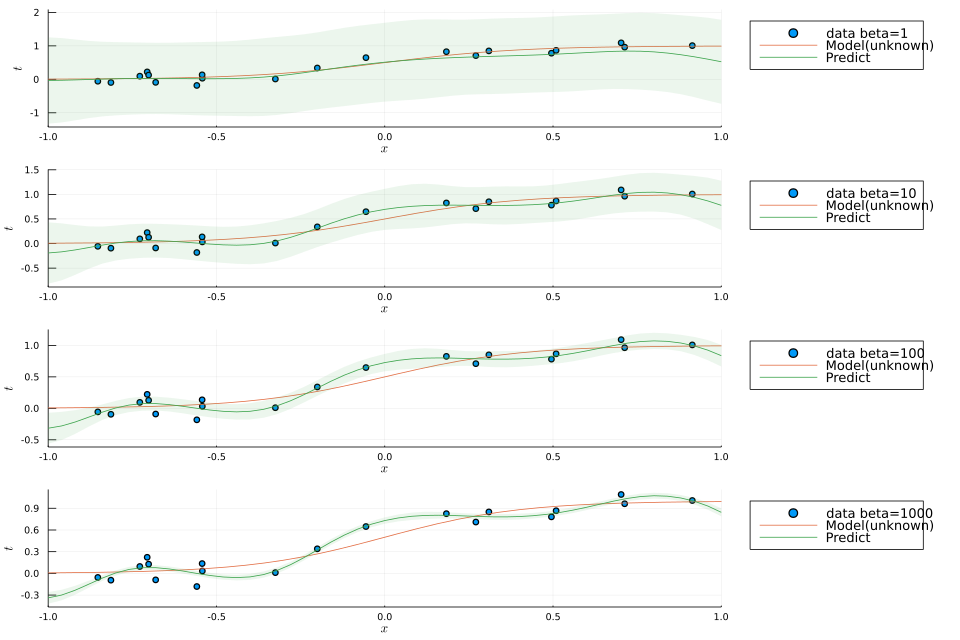

In [25]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for β in [1, 10, 100, 1000]
    @show β
    μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian10, β, 1)
    plt = myplot(x_data, t_data, x_dense, μ_dense, σ_dense, desc="beta=$(β)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))

#### 基底の数

n = 2
n = 5
n = 10
n = 50


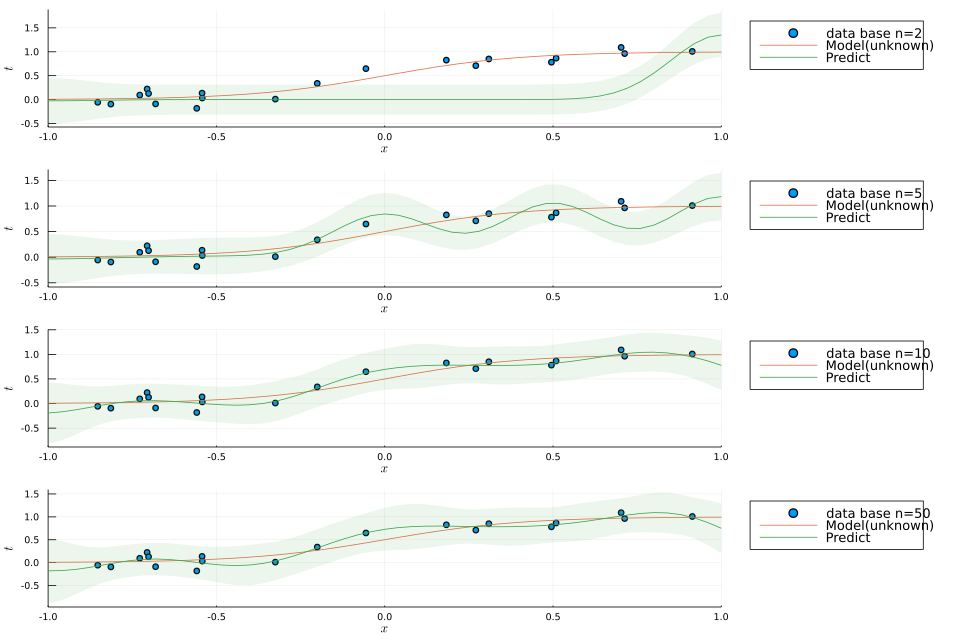

In [26]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for n in [2, 5, 10, 50]
    @show n
    bases_gaussian(x) = bases_gaussian(x, -1, 1, n, 0.15)
    μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian, 10, 1)
    plt = myplot(x_data, t_data, x_dense, μ_dense, σ_dense, desc="base n=$(n)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))

#### 基底の幅

w = 0.01
w = 0.1
w = 1.0
w = 10.0


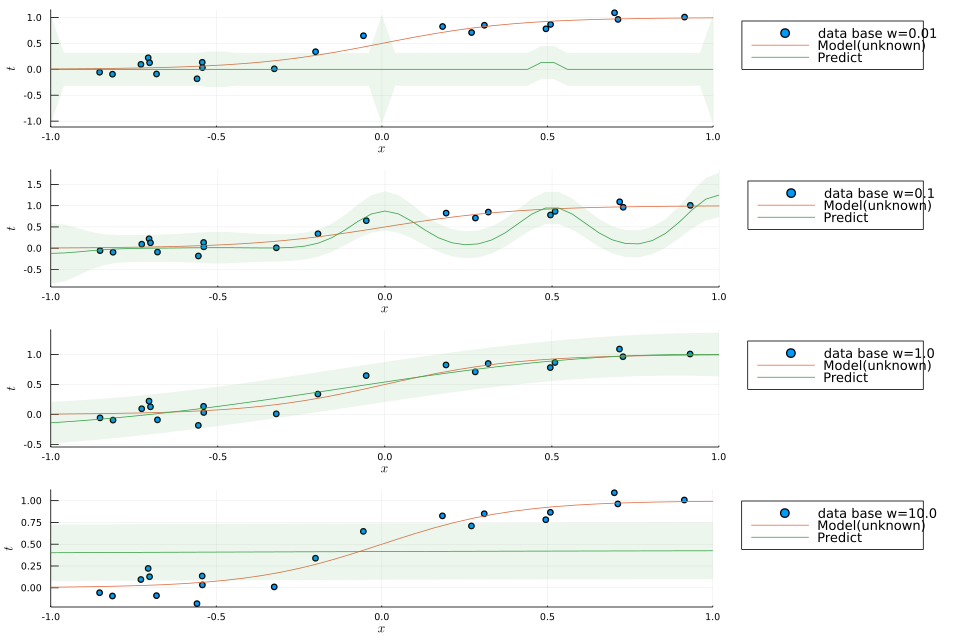

In [27]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for w in [0.01, 0.1, 1, 10]
    @show w
    bases_gaussian(x) = bases_gaussian(x, -1, 1, 5, w)
    μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian, 10, 1)
    plt = myplot(x_data, t_data, x_dense, μ_dense, σ_dense, desc="base w=$(w)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))

w = 0.01
w = 0.1
w = 1.0
w = 10.0


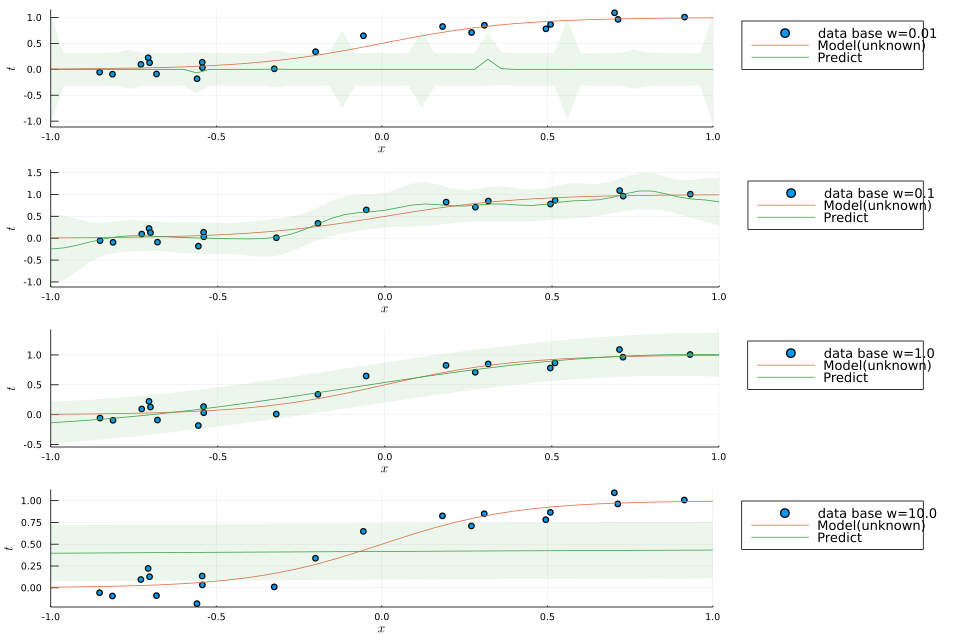

In [28]:
plts = []
#x_data, t_data, x_dense, t_dense = make_data_rtn(N=20)
for w in [0.01, 0.1, 1, 10]
    @show w
    bases_gaussian(x) = bases_gaussian(x, -1, 1, 10, w)
    μ_dense, σ_dense = bayes_linear_regression(FT, x_data, t_data, x_dense, bases_gaussian, 10, 1)
    plt = myplot(x_data, t_data, x_dense, μ_dense, σ_dense, desc="base w=$(w)")
    push!(plts, plt)
end
myplots(plts, figsize=(1200, 800))